<a href="https://colab.research.google.com/github/rifqoi/BERT-Sentiment-Analysis/blob/main/11-indoberttweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/kamus_alay.csv
!wget https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/flip_cat_balance.tsv
!wget https://raw.githubusercontent.com/datascienceid/stopwords-bahasa-indonesia/master/stopwords_id_satya.txt -O stopword.txt
!wget https://cdn.discordapp.com/attachments/818681954303868938/994060411366281216/2kdata.json

--2022-07-08 06:33:29--  https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/kamus_alay.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49923 (49K) [text/plain]
Saving to: ‘kamus_alay.csv’

kamus_alay.csv      100%[===================>]  48.75K  --.-KB/s    in 0.01s   

2022-07-08 06:33:29 (4.20 MB/s) - ‘kamus_alay.csv’ saved [49923/49923]

--2022-07-08 06:33:29--  https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/flip_cat_balance.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 

In [2]:
!pip install emoji
!pip install Sastrawi
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 4.3 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=7bee47695c5c523cc0e0f2ec3b16adbe83cf19b117d1924283c57e083bc387f9
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 4.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 47.5 MB/s 
     |████████████████████████████████| 101 kB 10.8 MB/s 
     |████████████████████████████████| 6.6 MB 48.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
 

In [60]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict
import string

# NLP
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import emoji

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

import tensorflow as tf

from transformers import TFBertForSequenceClassification, BertConfig, BertTokenizer, TFAutoModelForSequenceClassification, TFAutoModel
from transformers import InputExample, InputFeatures
import transformers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Import data
df = pd.read_json("2kdata.json")

In [5]:
df = df.sample(frac=1)

In [6]:
df = df[["tweets", "sentiment"]]
df

,tweets,sentiment
2038,Yang membalap siapa saja...?,Neutral
566,Mawas diri juga PSI ya mengatai gubernur DKI J...,Negative
932,"Malah sibuk bikin formula E ngga jelas , JIS j...",Negative
845,Jangan sampai terjadi di sirkuit Formula E Jak...,Neutral
950,Sebagai kota dunia jakarta akan lebih elegan d...,Positive
...,...,...
1435,jelas formula e karena di jakarta 🙏,Neutral
1845,Yuk kita semua Sukseskan Formula E mantap nih ...,Positive
1499,Ssmoga Formula E di Jakarta lebih sukses pak Gub,Positive
1839,"Kmren mau nntn balapan ke jauhan,bantu Suksesk...",Positive


In [ ]:
df.tweets = df.tweets.apply(lambda x: x.lower())
df

,tweets,sentiment
27,mengawasi proyek sumur resapan yg pembangunann...,Negative
1684,itukan jelas belum ada perencanaan. masih perl...,Negative
898,"mungkin sesi jakarta, formula e nya pake vr, j...",Negative
1069,apa yang sehatkan dan pulihkan ekonomi jakarta...,Positive
465,prestasi paling menonjol adalah meresapkan ang...,Negative
...,...,...
1801,gak jauh ada sirkuit formula e.. makin keren ...,Positive
261,jadi ngga sabar pengen nonton formula e di jak...,Positive
1160,formula e.. kemanfaatannya cm buat anies.. n...,Negative
1610,formula e menjadi salah satu acara internasion...,Neutral


In [ ]:
count = 0
for x in df.itertuples():
  if count == 10:
    break
  print(x.tweets)
  count += 1

4 tahun di jakarta cuma dpt stadion jis (cuma numpang nyelsein) dan formula e yg belum jelas blas...... makan tu gubernur seagama.... cukup jakarta aja yg dibohongin
harusnya tulisannya enjoy jakarta karena formula e sukses nama indonesia pasti terbawa juga, selama ini proses pengerjaan hingga pembangunan melalui jalan yg terjal dan curam cobaan demi cobaan dilalui hingga saat ini, tapi disayangkan kesannya projek ini hanya projek pemda dki.
nah loh belum ada progres apa"udah ada biaya tambahan ke kontraktor untuk bikin sirkkuit formula e ini adalah azab dari allah swt tidak merestui evert formula e untuk pemprov dki jakarta yang suka bohongin rakyatnya,dan juga mengatasnamakan pemulihan ekonomi rakyat dki jakarta.
s7 , tapi kasih tau dong, pembalap yg terkenal d formula e... soalnya kemarin jakarta antusias menyambut pembalap gp kayak marquez, daviouoso dll... gimana mau d tonton kalo pembalapnya ga ada yg kenal....😃😃😃😃
satu aja harapan dan doa saya, semoga tidak ada sabotase dari pih

In [10]:
def clean_data(x):
    x = x.lower()
    # Menghapus @username
    x = re.sub(r"@[A-Za-z0-9]\w+", "", x)  # Remove @
    # Menghapus link website
    x = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", x)  # Remove http links
    # Menghapus new line
    x = re.sub(r"\n", " ", x)
    # Menghapus whitespace pada sekitar kalimat
    x = x.strip()
    # Menghapus hashtag
    x = re.sub(r"\B(#\w+)+", r" ", x)
    # Mengubah % menjadi persen
    x = re.sub(r"(\d+) ?%", "\\1 persen", x)
    # Mengubah emoji menjadi kata 
    x = emoji.demojize(x, delimiters=(" ", " ")) 
    # Menghapus simbol-simbol
    x = re.sub(r"[^\w]", " ", x)
    # Menghapus huruf berulang 
    x = re.sub(r'(.)\1+', r'\1\1', x)     
    # Menghapus spasi berulang
    x = re.sub('\s+', ' ', x)

    return x


In [33]:
kamus_alay = pd.read_csv('kamus_alay.csv')

alay_word_dict = {}

for ele in kamus_alay.itertuples():
  alay_word_dict[ele.slang] = ele.formal

# Custom kata alay wokwokw
custom_word = {
    "bong": "cebong",
    "bongg": "cebong",
    "cebi": "cebong",
    "cebii": "cebong",
    "drun": "kadrun",
    "drunn": "kadrun",
    "druunn": "kadrun",
    "gabener": "gubernur",
    "gabenerr": "gubernur",
    "goodbener": "gubernur",
    "goodbenerr": "gubernur",
    "gotbener": "gubernur",
    "gub": "gubernur",
    "gutbener": "gubernur",
    "gutbenerr": "gubernur",
    "even": "event",
    "komitmen":  "commitment",
    "komitmenn":  "commitment",
    "komitmeen":  "commitment",
    "commitmentt": "commitment",
    "committmeentt": "commitment",
    "ayoo": "ayo",
    "ayok": "ayo",
    "ayook": "ayo",
    "ayokk": "ayo",
    "ayookk": "ayo",
    "kuy": "ayo",
    "kuyy": "ayo",
    "knapa": "kenapa",
    "knapaa": "kenapa",
    "knp": "kenapa",
    "knpa": "kenapa",
    "knpaa": "kenapa",
    "enggak": "tidak",
    "enggakk": "tidak",
    "enggaak": "tidak",
    "enggaakk": "tidak",
    "gak": "tidak",
    "nis": "anies",
    "niss": "anies",
    "nies": "anies",
    "niess": "anies",
    "niies": "anies",
    "niiees": "anies",
    "niieess": "anies",
    "anis": "anies",
    "aniss": "anies",
    "aniis": "anies",
    "aniiss": "anies",
    "aniess": "anies",
    "aniiess": "anies",
}

alay_word_dict.update(custom_word)

def normalize_text(x):
  # Ubah kata alay menjadi formal
  x = [alay_word_dict[word] if word in alay_word_dict else word for word in x]
  return x


In [34]:
# Stopwords
from nltk.corpus import stopwords
stopwords_list = set(stopwords.words('indonesian'))

negation_words = ['tak', 'tidak', 'gak', 'enggak', 'nggak', 'jangan', 'bukan']
strong_words = ["sekali", 'sangat', 'terlalu', 'amat', 'benar', 'makin']
other_words = ["hari", "jauh", "siapa", "kenapa", "bagaimana", ""]
stopwords_to_remove = [negation_words, strong_words, other_words]

with open('./stopword.txt') as f:
  custom_stopwords = f.read().splitlines()

for words_list in stopwords_to_remove:
  for word in words_list:
    stopwords_list.discard(word)

def remove_stopwords(x):
  x = [word for word in x if word not in stopwords_list]
  return x

print(len(stopwords_list))
print(len(custom_stopwords))

741
357


In [35]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stemmer.stem("mengembalikan")
def stemming_text(x):
  x = [stemmer.stem(word) for word in x]
  return x

# df_stemmed = df_stripped_stopwords.copy()
# df_stemmed["tweets"] = df_stemmed.tweets.apply(stemming_text)
# df_stemmed

In [36]:
def preprocess_data(df, stem=False):
  df_processed = df.copy()
  df_processed.tweets = df_processed.tweets.apply(clean_data)
  df_processed.tweets = df_processed.tweets.apply(word_tokenize)
  df_processed.tweets = df_processed.tweets.apply(normalize_text)
  df_processed.tweets = df_processed.tweets.apply(remove_stopwords)
  if stem:
    df_processed.tweets = df_processed.tweets.apply(stemming_text)
  df_processed.tweets = df_processed.tweets.apply(lambda x: ' '.join(x))
  df_processed.sentiment = df_processed.sentiment.map({
    "Positive": 0,
    "Neutral": 1,
    "Negative": 2,
  })
  return df_processed

df_preprocessed = preprocess_data(df)
df_preprocessed

,tweets,sentiment
2038,membalap siapa,1
566,mawas psi ya mengatai gubernur dki jakarta str...,2
932,sibuk bikin formula e enggak jis ok sih dibare...,2
845,jangan sirkuit formula e jakarta bisa2 dihujat...,1
950,kota dunia jakarta elegan formula e balapannya...,0
...,...,...
1435,formula e jakarta folded_hands,1
1845,yuk sukseskan formula e mantap nih balapan jak...,0
1499,ssmoga formula e jakarta sukses gubernur,0
1839,kemarin menonton balapan jauhan bantu sukseska...,0


In [37]:
print(df_preprocessed.tweets[845])
df.tweets[845]

jangan sirkuit formula e jakarta bisa2 dihujat 7 turunan


'Jangan sampai terjadi di sirkuit Formula E Jakarta. Bisa2 dihujat 7 turunan.'

In [38]:
df.tweets[1801]

'Gak jauh ada sirkuit Formula E..  makin keren Jakarta sebagai salah satu kota ramah lingkungan'

In [39]:
def make_corpus(column):
    
    text_body = ""


    for sentences in column:
      sentences = sentences.split(' ')
      text_body += ' ' +' '.join(sentences)

    print(text_body)
    # transform list of words into 1 body of text
    corpus = re.sub('[ ]+',' ', text_body) # replace double whitespace with one
        
    return corpus

In [40]:
# Takes a while
corpus = make_corpus(df_preprocessed.tweets)

 membalap siapa mawas psi ya mengatai gubernur dki jakarta stres formula e tidak layak tiru masyarakat hargai hormati orang hargai hormati orang rumus sosial baku sibuk bikin formula e enggak jis ok sih dibarengi urus kali kali jakarta utama hancur deh uang enggak prioritas parah jangan sirkuit formula e jakarta bisa2 dihujat 7 turunan kota dunia jakarta elegan formula e balapannya ikon kota pariwisata go green city waa cocok dilaksanakan jakarta dibandingkan formula e arenanya tersedia titik titik nya thinking_face thinking_face thinking_face deh pembalap jakarta indonesia tampil formula e anggaran milyaran tidak mengembangkan pembalap2 lokal otomatis event sangat potensi memperkenalkan jakarta mata dunia orang picik menghambatnya ego dengkinya dikedepankan kebaikan dianggapnya keburukan sukses formula e amin motogp mandalika terlaksana next semoga formula e jakarta berjalan menikmati hiburan enggak usah pakai isu isu politis dukung keren negara formula e tiketnya diskon warga jakarta

In [41]:
# counting unique words
corpus_set = set(corpus.split(' '))

print(f'Count of unique words in corpus: {len(corpus_set)}')

Count of unique words in corpus: 6267


In [42]:
# function for freqdist
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    freqdist = freqdist.most_common(top) # list of tuples 
    
    # decompose into label and frequency
    label = [tup[0] for tup in freqdist]
    freq = [tup[1] for tup in freqdist]
    df = pd.DataFrame({'word':label, 'freq':freq})
    
    return df

In [43]:
corpus_freq = word_freq(corpus, top=20)

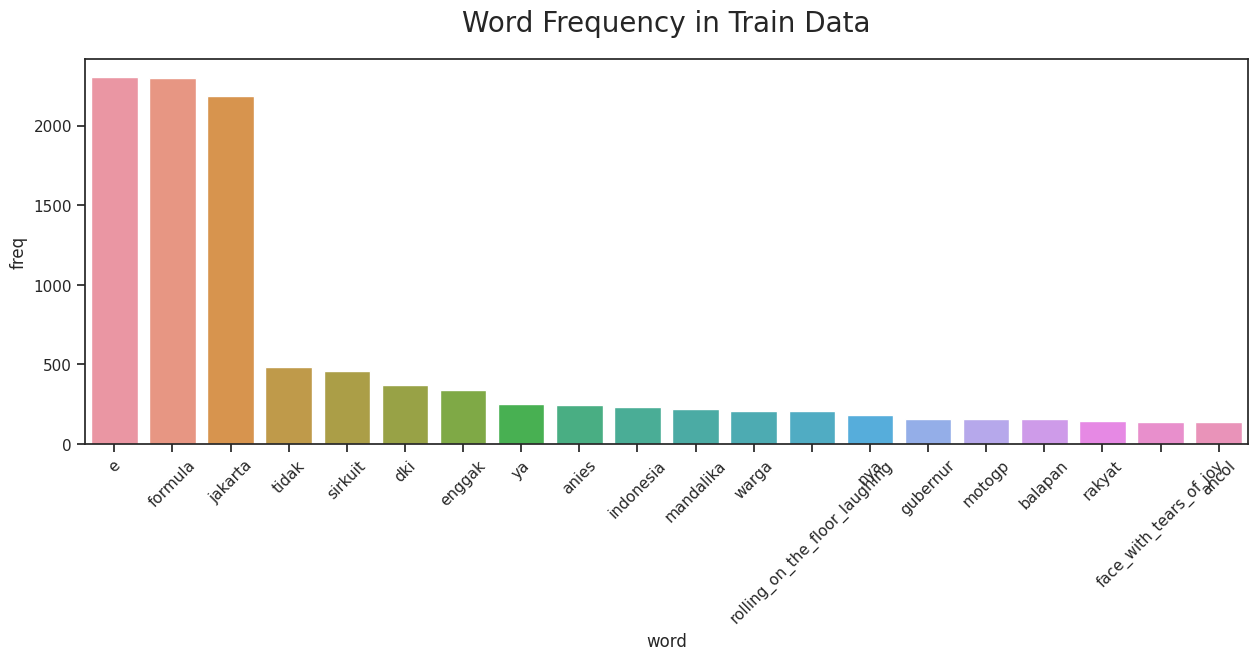

In [44]:
# Config params
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, ax1 = plt.subplots(1,figsize=(15,5))

sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax1)
ax1.set_title('Word Frequency in Train Data')
ax1.tick_params(axis='x', rotation=45)

# sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax2)
# ax2.set_title('Word Frequency in Train Data')
# ax2.tick_params(axis='x', rotation=45)

# sns.despine(ax=ax1)
# sns.despine(ax=ax2)
plt.show()

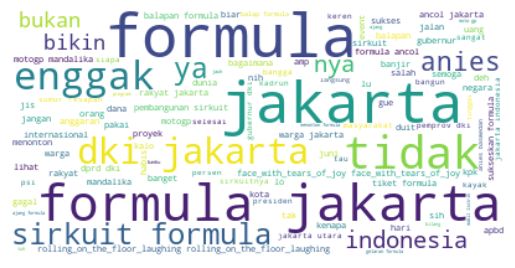

In [45]:
# Cloud for corpus
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [46]:
# train val split
train_set, val_set = train_test_split(df_preprocessed, test_size=0.3, stratify=df_preprocessed.sentiment)
# val_set, test_set = train_test_split(val_set, test_size=0.33, stratify=val_set.sentiment, random_state=1)

In [50]:
def convert_data_to_examples(input_set,  DATA_COLUMN, LABEL_COLUMN):
  set_InputExamples = input_set.apply(lambda x: InputExample(guid=None,
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  return set_InputExamples


In [107]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            padding='max_length',
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

In [108]:
def convert_data_to_tf_dataset(train, val, data_column, label_column, tokenizer):
  train_InputExamples = convert_data_to_examples(train, data_column, label_column)
  validation_InputExamples = convert_data_to_examples(val, data_column, label_column)
  
  train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
  train_data = train_data.shuffle(100).batch(32).repeat(2)
  
  validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
  validation_data = validation_data.batch(32)
  return train_data, validation_data


In [109]:
def bert_model(pretrained_model, from_pt=False):
  tokenizer = BertTokenizer.from_pretrained(pretrained_model)
  config = BertConfig.from_pretrained(pretrained_model)
  config.labels = 3
  
  base_model = TFAutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=3, from_pt=from_pt)
  return base_model, tokenizer
model, tokenizer = bert_model('indolem/indobertweet-base-uncased', from_pt=True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [110]:
len([3, 1892, 2805, 6928, 47, 8153, 13563, 6265, 3890, 10414, 1580, 3680, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

128

In [111]:
print(tokenizer.all_special_ids)
print(tokenizer.all_special_tokens)

[1, 4, 0, 3, 2]
['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']


In [112]:
DATA_COLUMN = 'tweets'
LABEL_COLUMN = 'sentiment'

train_data, validation_data = convert_data_to_tf_dataset(train_set, val_set, DATA_COLUMN, LABEL_COLUMN, tokenizer)

In [88]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-6, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

history = model.fit(train_data, epochs=7, validation_data=validation_data)

Epoch 1/7
90/90 [==============================] - 99s 885ms/step - loss: 0.8671 - accuracy: 0.6516 - val_loss: 0.8144 - val_accuracy: 0.6639
Epoch 2/7
90/90 [==============================] - 78s 862ms/step - loss: 0.7690 - accuracy: 0.6958 - val_loss: 0.7457 - val_accuracy: 0.7133
Epoch 3/7
90/90 [==============================] - 78s 861ms/step - loss: 0.6924 - accuracy: 0.7261 - val_loss: 0.7023 - val_accuracy: 0.7166
Epoch 4/7
90/90 [==============================] - 77s 861ms/step - loss: 0.6117 - accuracy: 0.7657 - val_loss: 0.6757 - val_accuracy: 0.7166
Epoch 5/7
90/90 [==============================] - 78s 862ms/step - loss: 0.5471 - accuracy: 0.8011 - val_loss: 0.6862 - val_accuracy: 0.7298
Epoch 6/7
90/90 [==============================] - 78s 862ms/step - loss: 0.4864 - accuracy: 0.8240 - val_loss: 0.6744 - val_accuracy: 0.7414
Epoch 7/7
90/90 [==============================] - 77s 860ms/step - loss: 0.4229 - accuracy: 0.8548 - val_loss: 0.6849 - val_accuracy: 0.7430


In [ ]:
evaluate = model.evaluate(test_data)
print('Loss of the model is - ', evaluate[0])
print('Accuracy of the model is - ', evaluate[1]*100, '%')

classes =  ["Positive", "Neutral", "Negative"]
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

# print(classification_report(self.test_generator.classes, y_pred, target_names=classes))
# print('Confusion Matrix')
# conf_matrix = confusion_matrix(self.test_generator.classes, y_pred)
# df_cm = pd.DataFrame(conf_matrix, index = classes, columns = classes)
# ax = sns.heatmap(df_cm, annot=True, cmap='Blues')

# ax.set_title('Seaborn Confusion Matrix with labels\n\n')
# ax.set_xlabel('\nPredicted Values')
# ax.set_ylabel('Actual Values ')

7/7 [==============================] - 2s 298ms/step - loss: 1.5066 - accuracy: 0.7463
Loss of the model is -  1.5066324472427368
Accuracy of the model is -  74.6268630027771 %


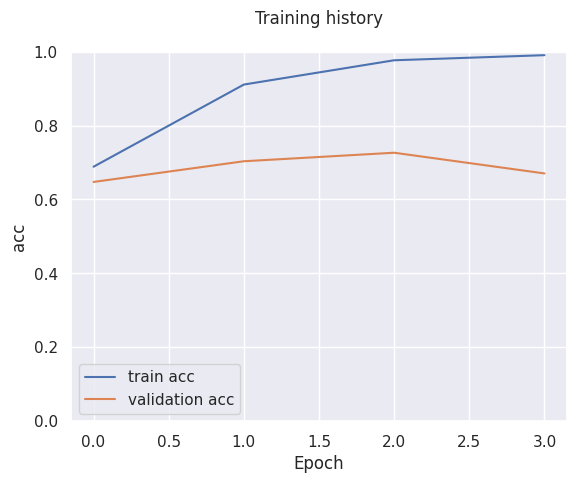

In [ ]:
sns.set()
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='validation acc')
plt.title('Training history')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

Overfit parah owkwokw

In [ ]:
test_sentences = list(test_set["tweets"])
tf_batch = tokenizer(test_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels =  ["Positive", "Neutral", "Negative"]
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(test_sentences)):
  print(test_sentences[i], ": ", labels[label[i]])

ValueError: ignored

In [ ]:
list(test_set["tweets"])

['Yth pak  , gelaran Moto3, moto2 &amp; MotoGP telah sukses digelar... Coba bapak berpikir jernih, untuk event Formula E yang akan digelar di Jakarta dipindah ke Mandalika pak. Karena sampai saat ini gak jelas juntrungannya, sampai kapan sirkuit formula E nya jadi...🙏',
 'dipikir formula e itu badan usaha milik dki jakarta apa ya',
 'Formula E buat taun depan, di jakarta, pasti lbh mahal lg tuh 🤭.  Tapi ya, kalo ga jadi lg mah atuh malu gubernur  nya wkwkwk',
 'Padahal pemerintah juga mendorong Formula E, FE atau MotoGP sama-sama nguntungin buat Indonesia itu sendiri padahal, jadi kontroversi karena diadain di Jakarta aja dan Gubernurnya pak Anies.',
 'Selesai saja belum....selesaikan dan laksanakan saja Formula E itu....daripada ditangkap KPK. Uang orang Jakarta sdh nggak jelas kemana....',
 'Saya mengharapkan event formula E jakarta juga sukses sbgmn event motogp mandalika. Pasti semua ada plus minusnya dalam penyelenggaraan, apalagi semua event perdana. Mudah2 kedepan semakin sukses